In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

## Getting set up

In [2]:
comp = 'godaddy-microbusiness-density-forecasting'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [3]:
!ls godaddy-microbusiness-density-forecasting

census_starter.csv  sample_submission.csv  test.csv  train.csv


Now we can import the stuff we'll need from fastai, set a seed (for reproducibility -- just for the purposes of making this notebook easier to write; I don't recommend doing that in your own analysis however) and check what's in the data:

In [4]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

## Looking at the data

In [5]:
df = pd.read_csv(path/'train.csv')

In [6]:
df.head(5)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [31]:
cats=['county','state']
conts=['active']
dep='microbusiness_density'
def xs_y(df):
    df[cats] = df[cats].apply(lambda x: x.cat.codes)
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

# trn_xs,trn_y = xs_y(trn_df)
# val_xs,val_y = xs_y(val_df)

In [8]:
df.county.nunique()

1871

In [9]:
df.state.nunique()

51

In [10]:
df.groupby('state').cfips.nunique().mean()

61.470588235294116

In [11]:
print('mean:',df.groupby(['county','state']).cfips.nunique().mean())
print('min:',df.groupby(['county','state']).cfips.nunique().min())
print('max:',df.groupby(['county','state']).cfips.nunique().max())

mean: 1.0
min: 1
max: 1


This data is county level, cfips code is just a join key

In [12]:
df.groupby(['state','county','first_day_of_month']).cfips.count().sort_values(ascending=False).min()

1

## Feature engineering

In [15]:
def feature_engineering(df):
    df.first_day_of_month = pd.to_datetime(df.first_day_of_month)
    df['month'] = df.first_day_of_month.dt.month
    df['year'] = df.first_day_of_month.dt.year
    df['yyyymm'] = df.first_day_of_month.dt.year*100 + df.first_day_of_month.dt.month
    df.county = pd.Categorical(df.county)
    df.state = pd.Categorical(df.state)

feature_engineering(df)
# proc_data(tst_df)

0.05 percentile: 0.81756973
0.95 percentile: 10.553019999999998


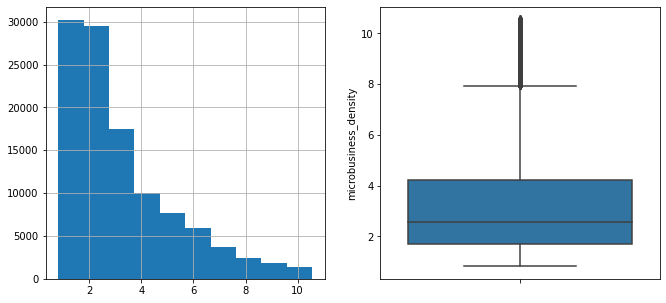

In [16]:
# remove outliers and plot
import seaborn as sns
fig,axs = plt.subplots(1,2, figsize=(11,5))
col = 'microbusiness_density'
min = 0.05
max = 0.95
df2 = df[(df[col]>df[col].quantile(q=min))&(df[col]<df[col].quantile(q=max))]
print('{} percentile: {}'.format(min,df[col].quantile(q=min)))
print('{} percentile: {}'.format(max,df[col].quantile(q=max)))
df2[col].hist(ax=axs[0])
sns.boxplot( y=df2[col], ax=axs[1]);

0.05 percentile: 35.0
0.9 percentile: 10380.200000000012


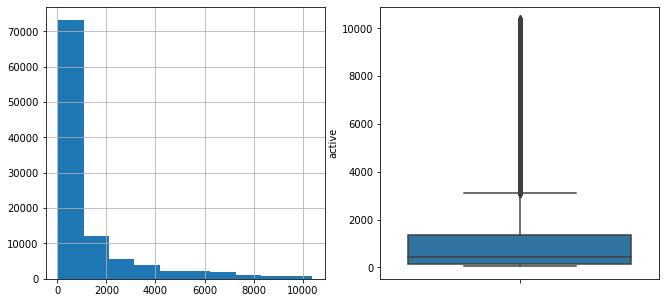

In [17]:
# remove outliers and plot
import seaborn as sns
fig,axs = plt.subplots(1,2, figsize=(11,5))
col = 'active'
min = 0.05
max = 0.90
df2 = df[(df[col]>df[col].quantile(q=min))&(df[col]<df[col].quantile(q=max))]
print('{} percentile: {}'.format(min,df[col].quantile(q=min)))
print('{} percentile: {}'.format(max,df[col].quantile(q=max)))
df2[col].hist(ax=axs[0])
sns.boxplot( y=df2[col], ax=axs[1]);

In [18]:
# m = DecisionTreeClassifier(min_samples_leaf=50)
# m.fit(trn_xs, trn_y)
# draw_tree(m, trn_xs, size=25)

## Our first model

In [32]:
from sklearn.model_selection import train_test_split
trn_df,val_df = train_test_split(df, test_size=0.25)

In [33]:
trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [35]:
trn_xs.county

94055     1348
105203    1220
114680    1593
120712    1568
17299      599
          ... 
2507      1769
43756      246
32335      735
38867      113
81378      997
Name: county, Length: 91698, dtype: int16

In [39]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);

0.15978394026889498

In [47]:
def calculate_smape(actual, predicted) -> float:
  
    # Convert actual and predicted to numpy
    # array data type if not already
    actual = np.array(actual)
    predicted = np.array(predicted)
  
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

In [49]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
print(mean_absolute_error(val_y, rf.predict(val_xs)))
print(calculate_smape(val_y, rf.predict(val_xs)))

0.15978394026889498
3.43


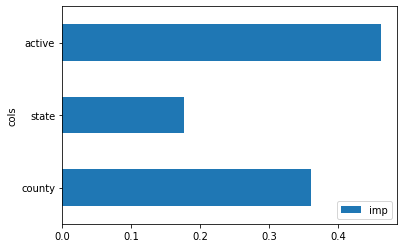

In [41]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

## Submitting to Kaggle

In [52]:
test_df = pd.read_csv(path/'test.csv')
test_df

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01
...,...,...,...
25075,56037_2023-06-01,56037,2023-06-01
25076,56039_2023-06-01,56039,2023-06-01
25077,56041_2023-06-01,56041,2023-06-01
25078,56043_2023-06-01,56043,2023-06-01


In [53]:
feature_engineering(test_df)

AttributeError: 'DataFrame' object has no attribute 'county'

In [ ]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

Let's submit this to kaggle. We can do it from the notebook if we're running on Kaggle, otherwise we can use the API:

In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

Success! We successfully created a submission.

## Conclusion

## Addendum

`fastkaggle` also provides a function that pushes a notebook to Kaggle Notebooks. I wrote this notebook on my own machine, and pushed it to Kaggle from there -- here's the command I used:

In [ ]:
if not iskaggle:
    push_notebook('madhaowagh', 'first-steps-road-to-the-top-part-1',
                  title='First Steps: Road to the Top, Part 1',
                  file='first-steps-road-to-the-top-part-1.ipynb',
                  competition=comp, private=False, gpu=True)